# Project Overview (Unknown Language Translation to English)

| 🔹 Term        | Definition                                                                 |
|----------------|---------------------------------------------------------------------------|
| **LLM**        | AI model trained on massive text data to understand, generate, and translate human-like language. |
| **Transformer**| Neural architecture using self-attention to model sequences efficiently; backbone of modern LLMs. |
| **T5 Small**   | Lightweight Transformer-based Seq2Seq model for text tasks; pretrained on English, limited resources. |


### 🚀 Seq2Seq T5 Model – Purposeful Challenges & Customization

1. **📂 Data Preparation**  
   - Generated **Train, Test, Val** separately from Grok, ChatGPT, Gemini.  
   - Three categories:  
     1️⃣ Mixed Bangla-English in English  
     2️⃣ Pure Bangla in Bangla words  
     3️⃣ Mixed Bangla-English (English in English Letter and Bangla in Bangla Letter)  
   - **Limited dataset**, no external Bangla text included.  
   - **🎯 Target column**: English translation – purpose: teach the new language to translate into English.

2. **⚙️ Model Selection**  
   - **T5 Small** chosen for resource constraints.  
   - Model is **unaware of Bangla**.  

3. **📝 Vocabulary & Tokenization**  
   - Extract vocab only from **generated Train & Val data**.  
   - Combine **T5 English tokens + new Bangla tokens**.  
   - Use **SentencePiece** for uniform tokenization.  

4. **🔧 T5 Configuration Changes**  
   - Increase **dropout & attention_dropout** for stability.  
   - Add **extra encoder & decoder layers** for capacity.  
   - Freeze base layers to preserve English knowledge.  

5. **🧩 Custom Layers / Blocks**  
   - **Adapter Layers**: lightweight residual blocks for parameter-efficient fine-tuning.  
   - **LoRA**: low-rank matrices on Q/K/V to inject Bangla patterns.  
   - **Adaptive Attention**: gating between decoder & encoder states.  

6. **⚡ Optimizer & Scheduler**  
   - Use **Adafactor** with automatic **relative step LR** and **warmup**.  

7. **📊 Performance Evaluation**  
   - **BLEU**: n-gram overlap (translation accuracy)  
   - **ROUGE-L**: longest common subsequence (fluency)  
   - **Perplexity / Log-Likelihood**: model confidence & prediction probability  
   - **Validation monitoring** with early stopping to prevent overfitting.  


# 📦 Import Libraries

In [1]:
# ============================
# Core Libraries
# ============================
!pip install transformers torch         # HuggingFace Transformers + PyTorch

#=============================
# Dynamic Learning Rate Finder
#=============================
!pip install torch-lr-finder

# ============================
# Evaluation Metrics
# ============================
!pip install rouge-score                # ROUGE scoring
!pip install evaluate                   # HuggingFace evaluate library
!pip install sacrebleu                  # BLEU scoring backend



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 104.1 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 76.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 72.4 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5


- T5 (Text-to-Text Transfer Transformer)
- Encoder-Decoder Architecture: The Encoder processes the input sequence, and the Decoder generates output sequence


In [45]:
# ============================
# Environment & OS
# ============================
import os
import shutil
import time

# ============================
# Core Libraries
# ============================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# ============================
# PyTorch: Core & Utilities
# ============================
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler        # Mixed precision training
from torchsummary import summary

# ============================
# Transformers / NLP
# ============================
from transformers import (
    AutoTokenizer, T5ForConditionalGeneration, T5Config, T5Tokenizer,
    get_linear_schedule_with_warmup
)
from transformers.models.t5.modeling_t5 import T5Block

# ============================
# Optimizer & Learning Rate Utilities
# ============================
from torch_lr_finder import LRFinder
from torch.optim.lr_scheduler import LambdaLR
import torch.optim as optim
from transformers import Adafactor

# ============================
# Evaluation Metrics
# ============================
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
from evaluate import load


# 📂 Load Datasets (Train and Val)

In [3]:
# === Train Dataset ===
training_dataset = pd.read_csv("/kaggle/input/bangla-english-custom-dataset/final-datasets/train-data.csv")
print("=================About Training Dataset======================")
print(f"shape of dataset: {training_dataset.shape}")
training_dataset.head(5)

=================About Training Dataset======================
shape of dataset: (4008, 2)


,Text,Target
0,Apni kemon achhen ajke? Ami chinta korchilam a...,How are you today? I was thinking whether you ...
1,Apni recently kemon feel korchen? Ami chinta k...,How have you been feeling lately? I was thinki...
2,Apni ki ajke kichu emotional feel korchen? Ami...,Are you feeling emotional today? I was thinkin...
3,Apni ki recently kono boro decision niyechhen?...,Have you recently made any big decision? I was...
4,Apni ki recently kichu kichu stress feel korch...,Have you recently felt some stress? I was thin...


In [4]:
# === Validation Dataset ===
valid_dataset = pd.read_csv("/kaggle/input/bangla-english-custom-dataset/final-datasets/val-data.csv")

print("=================About Validation Dataset======================")

print(f"shape of dataset: {valid_dataset.shape}")
valid_dataset.head(5)

=================About Validation Dataset======================
shape of dataset: (945, 2)


,Text,Target
0,Apnar kotha shune amar khub shanti lage. Kichu...,Listening to you gives me peace. I was a bit s...
1,Apni ajker jonno ki plan korechhen? Jodi time ...,What plans do you have for today? If you have ...
2,Ajke office e khub pressure chhilo. Apni ki kh...,There was a lot of pressure at the office toda...
3,Ajke onek rush chhilo rastay. Apni ki safe e b...,The roads were very rushed today. Did you retu...
4,Apnar shathe kotha bole amar mon ektu halka ho...,Talking with you makes my mind lighter. I try ...


# 🧽 Download Model to Perform Offline Work

In [5]:
model_name = "t5-small"

# The path to your saved tokenizer files
local_path = f"./{model_name}-tokenizer"

In [6]:
# download and load model and tokenizer
tokenizer=AutoTokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

# Save them to a specific local directory
tokenizer.save_pretrained(local_path)
model.save_pretrained(local_path)


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

# 🤖 Load Model

In [7]:
#Local directory
local_directory = f"./{model_name}-tokenizer"

#load tokenizer and model from local directory

tokenizer = AutoTokenizer.from_pretrained(local_directory)
model = T5ForConditionalGeneration.from_pretrained(local_directory)




In [8]:
# Print the desired attributes from tokenizer
print(f"T5TokenizerFast(name_or_path='{tokenizer.name_or_path}', \n"
      f"vocab_size={tokenizer.vocab_size}, \n"
      f"model_max_length={tokenizer.model_max_length}, \n"
      f"is_fast={tokenizer.is_fast}, \n"
      f"padding_side='{tokenizer.padding_side}', \n"
      f"truncation_side='{tokenizer.truncation_side}')")

T5TokenizerFast(name_or_path='./t5-small-tokenizer', 
vocab_size=32100, 
model_max_length=512, 
is_fast=True, 
padding_side='right', 
truncation_side='right')


| Component                     | Configuration / Notes                                                                 |
|--------------------------------|-------------------------------------------------------------------------------------|
| Embedding                     | `Embedding(32128, 512)`                                                             |
| FFN size                       | 2048                                                                                |
| Encoder / Decoder blocks       | 6 encoder + 6 decoder blocks                                                        |
| Relative Attention Bias        | `Embedding(num_buckets, num_heads)`                                                |
| Notes                          | 👉 More flexible than absolute positions; works well for long sequences and generalizes to unseen lengths |
| Model Match                     | That matches **T5-Small**                                                          |


In [ ]:
#model summary

print(f"About Model: \n {model}")

### 🔥 Encoder and Decoder Block

In [9]:
print(f"Encoder Block: \n{model.encoder.block[0]}\n\n")

print(f"Decoder Block: \n{model.decoder.block[0]}")

Encoder Block: 
T5Block(
  (layer): ModuleList(
    (0): T5LayerSelfAttention(
      (SelfAttention): T5Attention(
        (q): Linear(in_features=512, out_features=512, bias=False)
        (k): Linear(in_features=512, out_features=512, bias=False)
        (v): Linear(in_features=512, out_features=512, bias=False)
        (o): Linear(in_features=512, out_features=512, bias=False)
        (relative_attention_bias): Embedding(32, 8)
      )
      (layer_norm): T5LayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (1): T5LayerFF(
      (DenseReluDense): T5DenseActDense(
        (wi): Linear(in_features=512, out_features=2048, bias=False)
        (wo): Linear(in_features=2048, out_features=512, bias=False)
        (dropout): Dropout(p=0.1, inplace=False)
        (act): ReLU()
      )
      (layer_norm): T5LayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
)


Decoder Block: 
T5Block(
  (layer): ModuleList(
    (0): T5LayerSelfAttention(
      (SelfAttenti

In [10]:
print(f"Details of Output layer of model: \n{model.lm_head}")

Details of Output layer of model: 
Linear(in_features=512, out_features=32128, bias=False)


### ⚙️ Change Model Config

In [11]:
# Load and customize config
config = T5Config.from_pretrained('t5-small')
config.dropout_rate = 0.3        # Default is 0.1
config.attention_dropout_rate = 0.3  # Also increase attention dropout
# Set LayerDrop value (e.g., 0.1 = 10% chance to drop each layer during training)
config.layerdrop = 0.2 # Values like 0.1–0.2 are common starting points

# Load model with modified config
model = T5ForConditionalGeneration(config)


### 🔧Add Extra Encoder and Decoder Layer

In [12]:
# 1. Create new encoder block
extra_encoder_block = T5Block(model.config, has_relative_attention_bias=False)

# 2. Append to encoder stack
model.encoder.block.append(extra_encoder_block)

# 3. Create new decoder block
extra_decoder_block = T5Block(model.config, has_relative_attention_bias=False)

# 4. Append to decoder stack
model.decoder.block.append(extra_decoder_block)

# 5. Update config to reflect new layer counts
model.config.num_layers += 1
model.config.num_decoder_layers += 1

# After appending new blocks
model.config.num_layers = len(model.encoder.block)
model.config.num_decoder_layers = len(model.decoder.block)

print(f"Encoder layers: {len(model.encoder.block)}")
print(f"Decoder layers: {len(model.decoder.block)}")




Encoder layers: 7
Decoder layers: 7


# 🏗️ Injecting New corpus

In [ ]:
# custom_spm.model is enough (don't need custom_spm.vocab)
#tokenizer = T5Tokenizer(vocab_file="/kaggle/input/corpus-and-tokenizer/custom_spm.model")


# 📌 Sentence Tokenization Summary  

📑 **Corpus Creation**  
Collected and merged **4,953 rows** of Bangla-English text into a clean training corpus.  

⚙️ **Tokenizer Training**  
Trained a **SentencePiece Unigram tokenizer** with **9,338 vocabulary size** and **99.95% character coverage**.  

📂 **Output Files**  
Generated two key artifacts: **`custom_spm.model`** and **`custom_spm.vocab`**.  

🚀 **Usage**  
These files enable **consistent subword tokenization** for translation and text generation tasks.  

🔗 **Notebook**  
[Bangla-English Tokenization on Kaggle](https://www.kaggle.com/code/shiblinomani/bangla-english-tokenization)  


### 🎛️ Read Custom Vocab

In [13]:
# Purpose: Count the number of tokens in the custom SentencePiece vocab file.
custom_vocab_file = "/kaggle/input/tokenized-words/custom_spm.vocab"

with open(custom_vocab_file, "r", encoding="utf-8") as f:
    tokens = f.readlines()

num_tokens = len(tokens)
print(f"Number of tokens in custom_spm.vocab: {num_tokens}")


Number of tokens in custom_spm.vocab: 9338


### ✂️ Append New and Unique Tokens (Avoid Duplicate)



In [14]:
# Purpose: Read custom vocab file, extract tokens not already in the tokenizer, 
# prepare a list of new tokens to add, and save them to a new file.
custom_tokens = []

with open(custom_vocab_file, "r", encoding="utf-8") as f:
    for line in f:
        token = line.strip().split("\t")[0]  # token \t score
        if token not in tokenizer.get_vocab():  # avoid duplicates
            custom_tokens.append(token)

print(f"Number of new tokens to add: {len(custom_tokens)}")

# Save the new tokens to a file
new_tokens_file = "new_custom_tokens.txt"
with open(new_tokens_file, "w", encoding="utf-8") as f:
    for token in custom_tokens:
        f.write(token + "\n")

print(f"New tokens saved to: {new_tokens_file}")


Number of new tokens to add: 5680
New tokens saved to: new_custom_tokens.txt


### 🧩 Add new tokens with existing token

In [15]:
# Purpose: Add new custom tokens to the tokenizer and resize the model's token embeddings
# to accommodate the expanded vocabulary.
tokenizer.add_tokens(custom_tokens)
model.resize_token_embeddings(len(tokenizer))


The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Embedding(37780, 512)

### 📏 Save the model and tokenizer with Custom Vocab

In [17]:
#loacl path to save the token, model, config
file_path = "./t5-small-custom-model"
os.makedirs(file_path, exist_ok=True)

# Purpose: Save the tokenizer and model to the specified local directory
# so they can be reloaded later for inf# Save tokenizer, model, and config
tokenizer.save_pretrained(file_path)
model.save_pretrained(file_path)
model.config.save_pretrained(file_path)   # <- explicitly saves config.json

print(f"Model, tokenizer, and config saved at: {file_path}")



Model, tokenizer, and config saved at: ./t5-small-custom-model


In [18]:
# Move to working directory (optional)
%cd /kaggle/working

# Zip specific files/folders
!zip -r t5_small_model_files.zip t5-small-custom-model new_custom_tokens.txt

/kaggle/working
  adding: t5-small-custom-model/ (stored 0%)
  adding: t5-small-custom-model/tokenizer.json (deflated 81%)
  adding: t5-small-custom-model/tokenizer_config.json (deflated 95%)
  adding: t5-small-custom-model/config.json (deflated 63%)
  adding: t5-small-custom-model/special_tokens_map.json (deflated 85%)
  adding: t5-small-custom-model/added_tokens.json (deflated 72%)
  adding: t5-small-custom-model/generation_config.json (deflated 29%)
  adding: t5-small-custom-model/model.safetensors (deflated 7%)
  adding: t5-small-custom-model/spiece.model (deflated 48%)
  adding: new_custom_tokens.txt (deflated 64%)


In [19]:
!ls -lh /kaggle/working/t5_small_model_files.zip


-rw-r--r-- 1 root root 248M Aug 25 17:00 /kaggle/working/t5_small_model_files.zip


In [20]:
# Reload from local directory
tokenizer = T5Tokenizer.from_pretrained("./t5-small-custom-model")
model = T5ForConditionalGeneration.from_pretrained("./t5-small-custom-model")

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Some weights of the model checkpoint at ./t5-small-custom-model were not used when initializing T5ForConditionalGeneration: ['decoder.block.6.layer.1.DenseReluDense.wi.weight', 'decoder.block.6.layer.1.DenseReluDense.wo.weight']
- This IS expected if you are initializing T5ForConditionalGeneration from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing T5ForConditionalG

### 🏃Load the model and token with custom vocab 

In [ ]:
#Local directory
#local_directory = f"./{model_name}-tokenizer"

#load tokenizer and model from local directory

#tokenizer = AutoTokenizer.from_pretrained(local_directory)
#model = T5ForConditionalGeneration.from_pretrained(local_directory)




In [21]:
print("tokenizer.vocab_size:", tokenizer.vocab_size)  # ~32k (original)
print("len(tokenizer):", len(tokenizer))              # 38,554 (merged)

tokenizer.vocab_size: 32000
len(tokenizer): 37780


<h3> 📝 Note </h3>

- 📄 **custom_spm.vocab** → 9,338 tokens (all tokens from your new-language corpus)  
- 🔹 **Original T5 tokenizer** → 32,100 tokens  
- ➕ **New tokens to add** → 5,680  

```python
if token not in tokenizer.get_vocab():
    custom_tokens.append(token)
```
    
⚠️ Why only 12,186 tokens are added:
This only adds tokens that are NOT already in the T5 tokenizer.
Some tokens from your 10,000 new-language tokens may already exist in T5’s vocab (English words, punctuation, or symbols).
✅ Therefore, only unique tokens that don’t collide with T5’s original 32.1k are added → 5,680 in this case.

**✅ Now tokens are added to the current vocabulary of T5: `Embedding(37780, 512)`**





# 🛠️ Model Customization

| #   | Component     | Purpose / Role                                     | Importance                                                                                       |
| --- | ------------- | -------------------------------------------------- | ---------------------------------------------------------------------------------------------------------------- |
| 1️⃣ | Embeddings    | Initial layer for input tokens                     | 🛡️ Preserve pretrained embeddings, reduce memory, ensure stability on small dataset                             |
| 2️⃣ | Frozen Layers | Retain pretrained knowledge in lower layers        | ⚡ Maintains generalization, prevents catastrophic forgetting, adapts efficiently to Bangla → English translation |
| 3️⃣ | Encoder       | Maps Bangla/Banglish input → latent semantic space | ✅ Preserve pretrained knowledge, adapt only higher layers to Bangla                                              |
| 4️⃣ | Decoder       | Converts latent embeddings → English output tokens | 🎯 Learn mapping from Bangla latent space → fluent English sequences                                             |
| 5️⃣ | LM Head       | Generates final logits for output tokens           | ✍️ Required to produce correct English words corresponding to latent representation                              |


### Model config (after your edits)
| Setting                      | Value                              | Purpose (plain English)                                  |
|-----------------------------|------------------------------------|-----------------------------------------------------------|
| Base model                  | t5-small                           | Start from strong pretrained weights                      |
| Encoder layers              | 7 (6 + 1 extra)                    | Extra capacity to learn Bangla nuances                    |
| Decoder layers              | 7 (6 + 1 extra)                    | Extra capacity for fluent, faithful English generation    |
| dropout_rate                | 0.3 (↑ from 0.1)                   | Reduce overfitting; make representations more robust      |
| attention_dropout_rate      | 0.3 (↑ from 0.1)                   | Regularize attention; prevent head over-reliance          |
| layerdrop                   | 0.2                                | Randomly drop layers during training → better generalization |
| Relative attention bias     | First block only (unchanged)       | Stable positional inductive bias                          |
| Extra blocks’ rel. bias     | `has_relative_attention_bias=False`| Keep bias placement consistent with T5 design             |

### Training plan (what to freeze vs train)
| Part                       | Trainable? | Purpose (why this choice)                                       |
|---------------------------|------------|------------------------------------------------------------------|
| `model.shared` embedding  | ❌ Frozen   | Keep core token meanings stable across Bangla/English            |
| Encoder layers 0–2        | ❌ Frozen   | Preserve general syntax/semantics from pretraining               |
| Encoder layers 3–7        | ✅ Train    | Adapt higher layers to Bangla grammar & context                  |
| Decoder layers 0–7       | ✅ Train    | Produce fluent, accurate English aligned to Bangla input         |
| LM head (output layer)    | ✅ Train    | Map decoder states → target vocabulary effectively                |

> Notes: layer indices are 0-based. With your added blocks, there are **7 encoder** and **7 decoder** layers total.


### 🔒 Freezing Parameters

In [22]:
# 🔒 Purpose: Freeze certain parameters of the T5 model for fine-tuning
def freeze_parameters(model, freeze_encoder_until_layer):
    # 1. Freeze embeddings (shared input layer)
    for param in model.shared.parameters():
        param.requires_grad = False  # Embedding weights will not update

    # 2. Freeze encoder layers up to index freeze_encoder_until_layer-1
    # Example: freeze first 4 encoder layers → (0,1,2,3)
    for i, block in enumerate(model.encoder.block):
        requires = i >= freeze_encoder_until_layer  
        for p in block.parameters():
            p.requires_grad = requires  

    # 3. Unfreeze decoder fully
    for p in model.decoder.parameters():
        p.requires_grad = True  

    # 4. Unfreeze lm_head (output layer)
    for p in model.lm_head.parameters():
        p.requires_grad = True  


# ✅ freeze embeddings + first 3 encoder layers
freeze_parameters(model, freeze_encoder_until_layer=3)

# 🔍 Verify frozen parameters
for name, param in model.named_parameters():
    if not param.requires_grad:
        print("FROZEN:", name)

FROZEN: encoder.block.0.layer.0.SelfAttention.q.weight
FROZEN: encoder.block.0.layer.0.SelfAttention.k.weight
FROZEN: encoder.block.0.layer.0.SelfAttention.v.weight
FROZEN: encoder.block.0.layer.0.SelfAttention.o.weight
FROZEN: encoder.block.0.layer.0.SelfAttention.relative_attention_bias.weight
FROZEN: encoder.block.0.layer.0.layer_norm.weight
FROZEN: encoder.block.0.layer.1.DenseReluDense.wi.weight
FROZEN: encoder.block.0.layer.1.DenseReluDense.wo.weight
FROZEN: encoder.block.0.layer.1.layer_norm.weight
FROZEN: encoder.block.1.layer.0.SelfAttention.q.weight
FROZEN: encoder.block.1.layer.0.SelfAttention.k.weight
FROZEN: encoder.block.1.layer.0.SelfAttention.v.weight
FROZEN: encoder.block.1.layer.0.SelfAttention.o.weight
FROZEN: encoder.block.1.layer.0.layer_norm.weight
FROZEN: encoder.block.1.layer.1.DenseReluDense.wi.weight
FROZEN: encoder.block.1.layer.1.DenseReluDense.wo.weight
FROZEN: encoder.block.1.layer.1.layer_norm.weight
FROZEN: encoder.block.2.layer.0.SelfAttention.q.weight


## 🚀 Updating the Encoder Layers

| #  | Module / Concept               | Key Idea / Iconography                                                   | Chosen Value & Reasoning |
|----|--------------------------------|-------------------------------------------------------------------------|-------------------------|
| 1️⃣ | Adapter                        | 🔧 Bottleneck FFN layer; down → ReLU → up; residual connection; lightweight extra brain; preserves pretrained knowledge | `bottleneck = 64` → reduces dimensionality for efficiency, preserves key FFN features, adds residual for stability |
| 2️⃣ | LoRA: Preserve Knowledge       | 🧠 Base model frozen; 🪄 LoRA trains small matrices; 🛡️ avoids forgetting | `r = 8` → low-rank; balances trainable parameters and learning capacity |
| 3️⃣ | LoRA: Efficient Adaptation     | ⚡ Small dataset; 📉 less compute; 📝 captures new vocab & grammar       | Uses low-rank adapters → efficient adaptation without full fine-tuning |
| 4️⃣ | LoRA: Task & Language Specific | 🎯 Target key layers (Q/K/V); 💡 efficient adaptation                   | Focus on attention matrices → most impact for cross-lingual transfer |
| 5️⃣ | LoRA: Swap / Combine Languages | 🔄 Multiple adapters; 🌏 load per language; 🏗️ base model unchanged     | Separate adapters per language → modular and flexible multilingual support |
| 💡 | LoRA Analogy                   | 📘 Base = polyglot student; LoRA = Bangla phrasebook, lightweight & safe| Analogy clarifies purpose and efficiency |
| 6️⃣ | LoRA Integration               | 🏗️ LoRA added to q/k/v in all encoder blocks; Adapter added from block 2 onwards; efficiently adapts model without full fine-tuning | Combines Adapter + LoRA → minimal trainable parameters, maximal adaptation |


### Lightweight Extran Brain in Encoder

In [23]:
# 🔧 Purpose: Adapter module for parameter-efficient fine-tuning
class Adapter(nn.Module):
    def __init__(self, hidden_size, bottleneck=None):
        """
        Adapter layer:
        - Projects down to a smaller bottleneck dimension
        - Applies ReLU activation
        - Projects back to hidden size
        - Adds a residual connection
        """
        super().__init__()
        if bottleneck is None:
            bottleneck = min(hidden_size // 8, 64)
        
        self.down = nn.Linear(hidden_size, bottleneck) # Dim reduction
        self.relu = nn.ReLU()                          # Non-linearity            
        self.up = nn.Linear(bottleneck, hidden_size)   # Dim restoration

    def forward(self, x):
        # Residual connection: output = Adapter(x) + x
        return x + self.up(self.relu(self.down(x)))

#### Add LoRALinear Layer


In [24]:
# 🔗 Purpose: LoRALinear wraps a standard Linear layer with Low-Rank Adapters (LoRA)
class LoRALinear(nn.Module):
    def __init__(self, linear, r=8):
        """
        LoRA-enhanced Linear layer.
        - Keeps the original linear transformation frozen.
        - Adds trainable low-rank matrices A (down projection) and B (up projection).
        
        Args:
            linear (nn.Linear): The original linear layer to wrap.
            r (int): Rank of the low-rank adapters (small number, e.g., 4).
        """
        super().__init__()
        self.linear = linear   # Original pretrained layer (can be frozen)
        self.r = r

        in_features = linear.in_features
        out_features = linear.out_features

        if r > 0:
            # 🟢 LoRA low-rank adapters
            self.A = nn.Linear(in_features, r, bias=False)   # Down-projection
            self.B = nn.Linear(r, out_features, bias=False)  # Up-projection
        else:
            self.A = None
            self.B = None

    def forward(self, x):
        if self.r > 0:
            # Output = frozen original + LoRA update
            return self.linear(x) + self.B(self.A(x))
        else:
            return self.linear(x) 


### Add LoRA and Adapter

In [25]:
# Add LoRA and Adapters to T5 Encoder Blocks
for i, block in enumerate(model.encoder.block):
    sa = block.layer[0].SelfAttention
    
    # --- Add LoRA to q, k, v ---
    # --- Wrap existing q, k, v with LoRA ---
    sa.q = LoRALinear(sa.q, r=8)
    sa.k = LoRALinear(sa.k, r=8)
    sa.v = LoRALinear(sa.v, r=8)
    
    # --- Adapter only from block 2 onwards ---
    if i >= 2:
        ff = block.layer[1].DenseReluDense   # <-- encoder FFN is at layer[1], not layer[2]
        hidden_size = ff.wo.out_features
        ff.adapter = Adapter(hidden_size=hidden_size) # match FFN output size


In [26]:
print("======== Model Status after Customized the Encoder Section =========")
model

======== Model Status after Customized the Encoder Section =========


T5ForConditionalGeneration(
  (shared): Embedding(37780, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(37780, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): LoRALinear(
                (linear): Linear(in_features=512, out_features=512, bias=False)
                (A): Linear(in_features=512, out_features=8, bias=False)
                (B): Linear(in_features=8, out_features=512, bias=False)
              )
              (k): LoRALinear(
                (linear): Linear(in_features=512, out_features=512, bias=False)
                (A): Linear(in_features=512, out_features=8, bias=False)
                (B): Linear(in_features=8, out_features=512, bias=False)
              )
              (v): LoRALinear(
                (linear): Linear(in_features=512, out_features=512, bias=False)
                (A): Linear(in_features=512, out_features=8, bia

## 🚀 Add Adaptive Attention in Decoder Sections

| #  | Module / Concept           | Key Idea / Iconography                                                   | Chosen Value & Reasoning |
|----|----------------------------|-------------------------------------------------------------------------|-------------------------|
| 1️⃣ | Adaptive Attention + Gating | 🎯 Gate network adaptively combines encoder & decoder states; ⚡ context scaled by learnable parameter; 🔑 improves cross-attention focus | `hidden_size = 512` → matches T5-small decoder; `scale = ones(hidden_size)` → learnable scaling preserves magnitude; gate = linear(hidden_size, hidden_size) for per-dim adaptive weighting |
| 2️⃣ | Integration into Decoder   | 🏗️ Added after FFN / layer[1] in each decoder block; replaces static cross-attention output with gated adaptive output | Ensures decoder effectively balances source context & own hidden states; improves translation accuracy without modifying base attention |


In [27]:
# 🎯 Purpose: Adaptive Attention with gating mechanism
class AdaptiveAttention(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        # 🔑 Gating network to adaptively weight encoder vs decoder states
        self.gate = nn.Linear(hidden_size, hidden_size)
        self.scale = nn.Parameter(torch.ones(hidden_size))  # learnable scaling

    def forward(self, decoder_hidden, encoder_outputs):
        """
        decoder_hidden: [batch, tgt_len, hidden_size]
        encoder_outputs: [batch, src_len, hidden_size]
        """
        # 1️⃣ Compute attention scores
        attn_scores = torch.matmul(decoder_hidden, encoder_outputs.transpose(1, 2))  
        attn_weights = F.softmax(attn_scores, dim=-1)  # [batch, tgt_len, src_len]

        # 2️⃣ Context vector
        context = torch.matmul(attn_weights, encoder_outputs)  # [batch, tgt_len, hidden_size]

        # 3️⃣ Adaptive gating
        gate = torch.sigmoid(self.gate(decoder_hidden))  # [batch, tgt_len, hidden_size]
        adaptive_output = gate * context * self.scale + (1 - gate) * decoder_hidden

        return adaptive_output



In [28]:
#Add AdaptiveAttention after running layer[1], it runs adaptive_attention.
for i, block in enumerate(model.decoder.block):
    cross_attn = block.layer[1]  # cross-attention
    block.adaptive_attention = AdaptiveAttention(hidden_size=512)

### 🔑 Save and Load Final Custom Model

In [80]:
print("======== Model Status after Customized the Encoder and Decoder Section =========")
model

======== Model Status after Customized the Encoder and Decoder Section =========


T5ForConditionalGeneration(
  (shared): Embedding(37780, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(37780, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): LoRALinear(
                (linear): Linear(in_features=512, out_features=512, bias=False)
                (A): Linear(in_features=512, out_features=8, bias=False)
                (B): Linear(in_features=8, out_features=512, bias=False)
              )
              (k): LoRALinear(
                (linear): Linear(in_features=512, out_features=512, bias=False)
                (A): Linear(in_features=512, out_features=8, bias=False)
                (B): Linear(in_features=8, out_features=512, bias=False)
              )
              (v): LoRALinear(
                (linear): Linear(in_features=512, out_features=512, bias=False)
                (A): Linear(in_features=512, out_features=8, bia


### T5 Model config (after edits)
| Setting                      | Value                              | Purpose (plain English)                                  |
|-----------------------------|------------------------------------|-----------------------------------------------------------|
| Base model                  | t5-small                           | Start from strong pretrained weights                      |
| Encoder layers              | 7 (6 + 1 extra)                    | Extra capacity to learn Bangla nuances                    |
| Decoder layers              | 7 (6 + 1 extra)                    | Extra capacity for fluent, faithful English generation    |
| dropout_rate                | 0.3 (↑ from 0.1)                   | Reduce overfitting; make representations more robust      |
| attention_dropout_rate      | 0.3 (↑ from 0.1)                   | Regularize attention; prevent head over-reliance          |
| layerdrop                   | 0.2                                | Randomly drop layers during training → better generalization |
| Relative attention bias     | First block only (unchanged)       | Stable positional inductive bias                          |
| Extra blocks’ rel. bias     | `has_relative_attention_bias=False`| Keep bias placement consistent with T5 design             |

### Training plan (what to freeze vs train)
| Part                       | Trainable? | Purpose (why this choice)                                       |
|---------------------------|------------|------------------------------------------------------------------|
| `model.shared` embedding  | ❌ Frozen   | Keep core token meanings stable across Bangla/English            |
| Encoder layers 0–2        | ❌ Frozen   | Preserve general syntax/semantics from pretraining               |
| Encoder layers 3–6        | ✅ Train    | Adapt higher layers to Bangla grammar & context                  |
| Decoder layers 0–6        | ✅ Train    | Produce fluent, accurate English aligned to Bangla input         |
| LM head (output layer)    | ✅ Train    | Map decoder states → target vocabulary effectively                |

> Notes: layer indices are 0-based. With your added blocks, there are **7 encoder** and **7 decoder** layers total.

### Summary Table

| Part                                 | Trainable?      | Purpose / Notes                                         |
| ------------------------------------ | --------------- | ------------------------------------------------------ |
| Custom vocab                          | ✅ Trainable     | Existing tokens: 32,100 + New tokens: 5,680 → expand tokenizer with new tokens |
| `model.shared` (embedding)           | ❌ Frozen        | Input representation                                     |
| Encoder layers 0–2                    | ❌ Frozen        | Preserve pretrained knowledge                            |
| Encoder layers 3–N                    | ✅ Trainable     | Adapt to Bangla understanding                            |
| Decoder layers 0–N                    | ✅ Trainable     | Generate English output                                  |
| LM head                               | ✅ Trainable     | Map hidden → vocabulary                                  |
| `Adapter` modules in encoder/decoder | ✅ Trainable     | Parameter-efficient fine-tuning                           |
| `LoRALinear` (attention layers)       | ✅ Trainable     | Inject low-rank updates without full fine-tuning         |
| `AdaptiveAttention` in decoder        | ✅ Trainable     | Dynamically balance encoder vs decoder states            |




# 🛠️ Feature and Target

In [29]:
# After loading and optionally renaming columns in val_dataset

# Convert train dataset columns to lists
train_texts = training_dataset["Text"].tolist()      # Bangla sentences
train_targets = training_dataset["Target"].tolist()  # English translations

# Convert val dataset columns to lists
val_texts = valid_dataset["Text"].tolist()      # Bangla sentences
val_targets = valid_dataset["Target"].tolist()  # English translations


In [30]:
print(f"📌 Training Inputs Size: {len(train_texts)} and Training Target Size: {len(train_targets)}")
print(f"📌 Validation Inputs Size: {len(val_texts)} and Training Target Size: {len(val_targets)}")

📌 Training Inputs Size: 4008 and Training Target Size: 4008
📌 Validation Inputs Size: 945 and Training Target Size: 945


In [31]:
# ================================
# Remove empty or NaN entries
# ================================
train_texts = [str(t) for t in train_texts if str(t).strip() != ""]
train_targets = [str(t) for t in train_targets if str(t).strip() != ""]
val_texts = [str(t) for t in val_texts if str(t).strip() != ""]
val_targets = [str(t) for t in val_targets if str(t).strip() != ""]

# Optional: check sizes after cleaning
print(f"📌 Training Inputs Size: {len(train_texts)} and Training Target Size: {len(train_targets)}")
print(f"📌 Validation Inputs Size: {len(val_texts)} and Validation Target Size: {len(val_targets)}")


📌 Training Inputs Size: 4008 and Training Target Size: 4008
📌 Validation Inputs Size: 945 and Validation Target Size: 945


### 🗺️ Max Length of Text and Target 

In [32]:
train_source_lens = [len(tokenizer.encode(text)) for text in train_texts]
train_target_lens = [len(tokenizer.encode(text)) for text in train_targets]

print("Train Source lengths - max:", max(train_source_lens), "mean:", sum(train_source_lens)/len(train_source_lens))
print("Train Target lengths - max:", max(train_target_lens), "mean:", sum(train_target_lens)/len(train_target_lens))


val_source_lens = [len(tokenizer.encode(text)) for text in val_texts]
val_target_lens = [len(tokenizer.encode(text)) for text in val_targets]

print("Val Source lengths - max:", max(val_source_lens), "mean:", sum(val_source_lens)/len(val_source_lens))
print("Val Target lengths - max:", max(val_target_lens), "mean:", sum(val_target_lens)/len(val_target_lens))

Train Source lengths - max: 178 mean: 71.05963073852296
Train Target lengths - max: 229 mean: 77.11801397205589
Val Source lengths - max: 159 mean: 78.07619047619048
Val Target lengths - max: 157 mean: 86.34391534391534


### 🔹 Tokenization & Encoding for Seq2Seq Training

**Caption:** Prepares source and target sequences for training by tokenizing, padding, truncating, and masking padding tokens in labels.

**Short Summary:**  
This function converts raw source and target texts into token IDs suitable for the model. It also prepares labels with `-100` for padding tokens so that the loss is not computed on them.


In [33]:

# === Constants ===
SRC_MAX_LEN = 200
TGT_MAX_LEN = 250
#BATCH_SIZE = 8  # Adjust as needed

# === Encoding Function ===
def prepare_encodings(source_texts, target_texts, tokenizer, src_max_len, tgt_max_len):
    """
    Tokenizes source and target texts, prepares labels with -100 padding mask.
    Returns: input_encodings, labels
    """
    # Tokenize source (input) texts
    input_encodings = tokenizer(
        source_texts,
        padding="max_length",
        truncation=True,
        max_length=src_max_len,
        return_tensors="pt"
    )
    input_encodings["input_ids"] = input_encodings["input_ids"].long()
    input_encodings["attention_mask"] = input_encodings["attention_mask"].long()

    # Tokenize target (label) texts
    target_encodings = tokenizer(
        target_texts,
        padding="max_length",
        truncation=True,
        max_length=tgt_max_len,
        return_tensors="pt"
    )
    target_encodings["input_ids"] = target_encodings["input_ids"].long()
    target_encodings["attention_mask"] = target_encodings["attention_mask"].long()

    # Prepare labels (mask pad tokens)
    labels = target_encodings["input_ids"].clone()
    labels[labels == tokenizer.pad_token_id] = -100

    return input_encodings, labels


In [34]:
# === Prepare tokenized inputs and labels for training data ===
train_input_encodings, train_labels = prepare_encodings(
    train_texts, train_targets, tokenizer, SRC_MAX_LEN, TGT_MAX_LEN
)

# === Prepare tokenized inputs and labels for validation data ===
val_input_encodings, val_labels = prepare_encodings(
    val_texts, val_targets, tokenizer, SRC_MAX_LEN, TGT_MAX_LEN
)


In [35]:
# === Print and Decode Train Example ===
print("\n=== [Train] Input Encodings (Bangla) ===")
print("input_ids:\n", train_input_encodings["input_ids"])
print("attention_mask:\n", train_input_encodings["attention_mask"])

print("\n=== [Train] Target Encodings (English) ===")
train_target_ids = train_labels.clone()
train_target_ids[train_target_ids == -100] = tokenizer.pad_token_id  # For decoding
print("input_ids:\n", train_target_ids)

# Decode first train example
print("\n First train input (decoded):", tokenizer.decode(train_input_encodings["input_ids"][700], skip_special_tokens=True))
print("\n First train target (decoded):", tokenizer.decode(train_target_ids[700], skip_special_tokens=True))

# === Print and Decode Val Example ===
print("\n=== [Val] Input Encodings (Bangla) ===")
print("input_ids:\n", val_input_encodings["input_ids"])
print("attention_mask:\n", val_input_encodings["attention_mask"])

print("\n=== [Val] Target Encodings (English) ===")
val_target_ids = val_labels.clone()
val_target_ids[val_target_ids == -100] = tokenizer.pad_token_id  # For decoding
print("input_ids:\n", val_target_ids)

# Decode first val example
print("\n First val input (decoded):", tokenizer.decode(val_input_encodings["input_ids"][0], skip_special_tokens=True))
print("\n First val target (decoded):", tokenizer.decode(val_target_ids[0], skip_special_tokens=True))



=== [Train] Input Encodings (Bangla) ===
input_ids:
 tensor([[37686,     3,    23,  ...,     0,     0,     0],
        [37686,     3,    23,  ...,     0,     0,     0],
        [37686,     3,    23,  ...,     0,     0,     0],
        ...,
        [  205, 35260,     3,  ...,     0,     0,     0],
        [  411, 34902,     3,  ...,     0,     0,     0],
        [32757,     3,    29,  ...,     0,     0,     0]])
attention_mask:
 tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])

=== [Train] Target Encodings (English) ===
input_ids:
 tensor([[  571,    33, 34770,  ...,     0,     0,     0],
        [  571,     3,   107,  ...,     0,     0,     0],
        [ 1521, 34770,     3,  ...,     0,     0,     0],
        ...,
        [  180, 32442, 36675,  ...,     0,     0,     0],
        [  205, 33328,  6397,  ...,     0,     0

In [37]:

# Decode first train example
print("First train input (decoded):", tokenizer.decode(train_input_encodings["input_ids"][702], skip_special_tokens=True))
print("First train target (decoded):", tokenizer.decode(train_target_ids[701], skip_special_tokens=True, clean_up_tokenization_spaces=True))

print("=========================================================================================================")
# Decode first val example
print("First val input (decoded):", tokenizer.decode(val_input_encodings["input_ids"][0], skip_special_tokens=True))
print("First val target (decoded):", tokenizer.decode(val_target_ids[0], skip_special_tokens=True))


First train input (decoded): আপ নি কি আজ কে ride - sha re কর তে চা ন? আমি ভাব ছিলাম p assenger properly info rmed আ ছে কি না । S afety preca uti ons নি লে b et te r হ বে ।
First train target (decoded): Ha ve yo u r ecent ly plan ned a t rave l ro ut e? I wa s thin king wh et her the distance h as b een properly m easure d. F ollo wing the ro ut e will sa ve ti me.
First val input (decoded): Apn ar k oth a sh u ne ama r khu b shan ti l ag e. K ichu di n d hore a mi ek tu str ess e chhi lam. Apn ar sh om ort hon ama ke o nek sha hosh dey. A mi c hai ama der bo n dhu tto a ro d eep ho k. Apn ar m oto ma nu sh ama r ji bo n e o nek imp ort a nt.
First val target (decoded): L istening to yo u gi ves me p eace. I wa s a bit str essed th ese p ast da ys. Your sup por t gi ves me a lo t of cou ra ge. I wa nt our f ri ends hi p to gr ow d eep er. A pe rs on l ik e yo u is very imp ort a nt in my life.


# 🔮 Convert to pytorch Dataset

In [38]:
# 📚 Purpose: Custom Dataset for seq2seq translation tasks
class TranslationDataset(Dataset):
    def __init__(self, input_encodings, labels):
        """
        Stores input token IDs, attention masks, and labels for training.
        
        Args:
            input_encodings (dict): Tokenized source sequences from tokenizer
            labels (torch.Tensor): Target token IDs with padding masked as -100
        """
        self.input_ids = input_encodings["input_ids"]
        self.attention_mask = input_encodings["attention_mask"]
        self.labels = labels

    def __len__(self):
        # Return number of samples
        return self.labels.size(0)

    def __getitem__(self, idx):
        # Return a single sample as a dictionary
        return {
            "input_ids": self.input_ids[idx],
            "attention_mask": self.attention_mask[idx],
            "labels": self.labels[idx]
        }


In [39]:
# === Create Datasets ===
train_dataset = TranslationDataset(train_input_encodings, train_labels)
print(f"Convert to Pytorch Train Dataset: {train_dataset}")
val_dataset = TranslationDataset(val_input_encodings, val_labels)
print(f"Convert to Pytorch Train Dataset: {val_dataset}")

# === Create DataLoaders ===
BATCH_SIZE = 16  # adjust according to GPU memory
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)



Convert to Pytorch Train Dataset: <__main__.TranslationDataset object at 0x7b299887a590>
Convert to Pytorch Train Dataset: <__main__.TranslationDataset object at 0x7b2999021a50>


# 📤 Device Setup

| Precision     | Usage                       | Device             |
|---------------|----------------------------|------------------|
| Float16       | `model.half()`             | GPU only          |
| Float32       | `model.to(device)`         | GPU or CPU        |


In [40]:
# === Device Setup ===
device = "cuda" if torch.cuda.is_available() else "cpu"
# float 32
model.to(device)

# float 16 in GPU interface
#model.half().to(device)

T5ForConditionalGeneration(
  (shared): Embedding(37780, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(37780, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): LoRALinear(
                (linear): Linear(in_features=512, out_features=512, bias=False)
                (A): Linear(in_features=512, out_features=8, bias=False)
                (B): Linear(in_features=8, out_features=512, bias=False)
              )
              (k): LoRALinear(
                (linear): Linear(in_features=512, out_features=512, bias=False)
                (A): Linear(in_features=512, out_features=8, bias=False)
                (B): Linear(in_features=8, out_features=512, bias=False)
              )
              (v): LoRALinear(
                (linear): Linear(in_features=512, out_features=512, bias=False)
                (A): Linear(in_features=512, out_features=8, bia

In [41]:
print(f"Details of Output layer of model: \n{model.lm_head}")

Details of Output layer of model: 
Linear(in_features=512, out_features=37780, bias=False)


# 🏆 Model Training and Evaluation

| #  | Name / Type                     | Short Code Summary / Purpose                                                                 |
|----|---------------------------------|---------------------------------------------------------------------------------------------|
| 1️⃣ | `create_optimizer_and_scheduler` | Function: Creates Adafactor optimizer with built-in dynamic LR schedule; no external scheduler needed. |
| 2️⃣ | `Seq2SeqTrainer`                 | Class: Implements custom seq2seq training loop, validation, early stopping, and model saving. |
| 3️⃣ | `__init__`                       | Method: Initializes trainer; sets model, tokenizer, dataloaders, device, optimizer, scaler, epochs, patience, and tracking variables. |
| 4️⃣ | `run_train_epoch`                | Method: Performs one epoch of training; uses mixed precision (`torch.amp`), gradient clipping, and tracks training loss. |
| 5️⃣ | `run_val_epoch`                  | Method: Performs one epoch of validation; computes average loss; tracks total validation time. |
| 6️⃣ | `save_model`                     | Method: Saves model and tokenizer to disk; prints path of saved model. |
| 7️⃣ | `fit`                            | Method: Main training loop; runs train + validation per epoch, applies early stopping, tracks total time. |
| 8️⃣ | `plot_losses`                    | Method: Plots training and validation loss curves for visual inspection of convergence. |
| 9️⃣ | `optimizer = Adafactor(...)`     | Adafactor optimizer: Supports relative step learning rate, warmup, and scaling; used for large-scale seq2seq training. |
| 🔟 | `self.scaler = GradScaler(...)`  | Mixed precision: Scales gradients to prevent underflow in float16 training; only enabled on GPU. |
| 11️⃣ | `torch.nn.utils.clip_grad_norm_` | Clips gradients to max norm (1.0) to stabilize training and prevent exploding gradients. |
| 12️⃣ | `tqdm(self.train_dataloader)`   | Provides progress bar for each training batch with live loss updates. |
| 13️⃣ | `total_val_time`                | Tracks total cumulative validation time across all epochs; used for monitoring efficiency. |


In [65]:
# ============================
# Optimizer & Scheduler
# ============================
def create_optimizer_and_scheduler(model):
    """
    Creates Adafactor optimizer with built-in dynamic LR schedule.
    """
    optimizer = Adafactor(
        model.parameters(),
        lr=None,              # Let Adafactor handle LR schedule
        relative_step=True,   # Dynamic LR per step
        scale_parameter=True, # Better with relative_step=True
        warmup_init=True      # Warmup + decay
    )

    # No external scheduler needed, return None
    scheduler = None

    return optimizer, scheduler


In [68]:
# ============================
# Seq2SeqTrainer with Adafactor
# ============================
class Seq2SeqTrainer:
    def __init__(self, model, tokenizer, train_dataloader, val_dataloader,
                 epochs=None, patience=None, optimizer=None, device=None):
        self.model = model
        self.tokenizer = tokenizer
        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.epochs = epochs
        self.patience = patience

        # Use Adafactor with automatic LR schedule if optimizer not provided
        if optimizer is None:
            self.optimizer = Adafactor(
                self.model.parameters(),
                lr=None,                 # Let Adafactor compute schedule
                scale_parameter=True,
                relative_step=True,
                warmup_init=True,
                weight_decay=0.0
            )
        else:
            self.optimizer = optimizer

        self.scaler = torch.amp.GradScaler(enabled=(self.device.type == "cuda"))

        self.train_losses = []
        self.val_losses = []
        self.best_val_loss = float('inf')
        self.patience_counter = 0

        self.model.to(self.device)

    # -----------------------------
    # Training one epoch
    # -----------------------------
    def run_train_epoch(self, epoch):
        self.model.train()
        total_loss = 0.0
        #Each Epoch start time
        start_time = time.time()
        loop = tqdm(self.train_dataloader, desc=f"Epoch {epoch+1} [Train]", leave=True)

        for batch in loop:
            self.optimizer.zero_grad()
            input_ids = batch["input_ids"].to(self.device)
            attention_mask = batch["attention_mask"].to(self.device)
            labels = batch["labels"].to(self.device)

            with torch.amp.autocast(device_type='cuda', enabled=(self.device.type=="cuda")):
                outputs = self.model(input_ids=input_ids,
                                     attention_mask=attention_mask,
                                     labels=labels)
                loss = outputs.loss

            self.scaler.scale(loss).backward()
            self.scaler.unscale_(self.optimizer)
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            self.scaler.step(self.optimizer)
            self.scaler.update()

            total_loss += loss.item()
            loop.set_postfix(loss=loss.item())
        
        epoch_time = time.time() - start_time
        avg_loss = total_loss / len(self.train_dataloader)
        self.train_losses.append(avg_loss)
        print(f"Epoch {epoch+1} Training Loss: {avg_loss:.4f} | Time: {epoch_time:.2f}s")
        return avg_loss

    # -----------------------------
    # Validation one epoch
    # -----------------------------
    def run_val_epoch(self, epoch):
        
        self.total_val_time = 0.0  # Add this to track total validation time

        self.model.eval()
        total_loss = 0.0
        
        # Start timing
        start_time = time.time()  

        with torch.no_grad():
            for batch in self.val_dataloader:
                input_ids = batch["input_ids"].to(self.device)
                attention_mask = batch["attention_mask"].to(self.device)
                labels = batch["labels"].to(self.device)

                outputs = self.model(input_ids=input_ids,
                                     attention_mask=attention_mask,
                                     labels=labels)
                total_loss += outputs.loss.item()

        avg_loss = total_loss / len(self.val_dataloader)
        self.val_losses.append(avg_loss)
        #Duration of each epochs
        epoch_time = time.time() - start_time
        # Accumulate total validation time
        self.total_val_time += epoch_time
        
        print(f"Epoch {epoch+1} Validation Loss: {avg_loss:.4f} | Time: {epoch_time:.2f}s")
        
        return avg_loss

    # -----------------------------
    # Save model
    # -----------------------------
    def save_model(self, path="t5_custom_model"):
        self.model.save_pretrained(path)
        self.tokenizer.save_pretrained(path)
        print(f"Model saved at {path}")

    # -----------------------------
    # Training loop with early stopping
    # -----------------------------
    def fit(self):
        print("Starting training...")
        total_start_time = time.time()

        for epoch in range(self.epochs):
            self.run_train_epoch(epoch)
            val_loss = self.run_val_epoch(epoch)

            # Early stopping
            if val_loss < self.best_val_loss:
                self.best_val_loss = val_loss
                self.patience_counter = 0
                self.save_model()
            else:
                self.patience_counter += 1
                print(f"No improvement. Patience: {self.patience_counter}/{self.patience}")
                if self.patience_counter >= self.patience:
                    print("Early stopping triggered.")
                    break

        total_duration = time.time() - total_start_time
        print(f"Total training duration: {total_duration:.2f}s")
        print(f"Total validation time: {self.total_val_time:.2f}s")


    # -----------------------------
    # Plot losses
    # -----------------------------
    def plot_losses(self):
        plt.figure(figsize=(10,5))
        plt.plot(self.train_losses, label='Train Loss')
        plt.plot(self.val_losses, label='Val Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()
        plt.grid(True)
        plt.show()


| #  | Name / Type                     | Short Code Summary / Purpose                                                                 |
|----|---------------------------------|---------------------------------------------------------------------------------------------|
| 1️⃣ | `EPOCHS`                        | Integer: Total number of training epochs; controls how many full passes over the dataset. |
| 2️⃣ | `PATIENCE`                       | Integer: Number of consecutive epochs without improvement in validation loss before early stopping. |
| 3️⃣ | `relative_lr`                    | Float / None: Learning rate for Adafactor; `None` allows Adafactor to manage dynamic LR automatically. |
| 4️⃣ | `optimizer = Adafactor(...)`     | Adafactor optimizer instance: Uses relative step scheduling, warmup, and scaling for stable seq2seq training. |
| 5️⃣ | `trainer = Seq2SeqTrainer(...)` | Initializes custom trainer with model, tokenizer, dataloaders, optimizer, epochs, patience, and device. |
| 6️⃣ | `trainer.fit()`                  | Runs full training loop: executes train + validation epochs with early stopping and saves best model. |
| 7️⃣ | `trainer.plot_losses()`          | Plots training vs validation loss curves for visual evaluation of model convergence. |


Starting training...


Epoch 1 [Train]: 100%|██████████| 251/251 [01:26<00:00,  2.89it/s, loss=5.73]


Epoch 1 Training Loss: 5.7162 | Time: 86.89s
Epoch 1 Validation Loss: 5.4277 | Time: 15.00s
Model saved at t5_custom_model


Epoch 2 [Train]: 100%|██████████| 251/251 [01:26<00:00,  2.91it/s, loss=5.12]


Epoch 2 Training Loss: 5.2253 | Time: 86.31s
Epoch 2 Validation Loss: 4.9659 | Time: 14.95s
Model saved at t5_custom_model


Epoch 3 [Train]: 100%|██████████| 251/251 [01:26<00:00,  2.91it/s, loss=4.55]


Epoch 3 Training Loss: 4.7902 | Time: 86.14s
Epoch 3 Validation Loss: 4.6893 | Time: 14.95s
Model saved at t5_custom_model


Epoch 4 [Train]: 100%|██████████| 251/251 [01:25<00:00,  2.92it/s, loss=4.37]


Epoch 4 Training Loss: 4.4749 | Time: 85.90s
Epoch 4 Validation Loss: 4.4821 | Time: 15.08s
Model saved at t5_custom_model


Epoch 5 [Train]: 100%|██████████| 251/251 [01:26<00:00,  2.91it/s, loss=4.01]


Epoch 5 Training Loss: 4.2251 | Time: 86.14s
Epoch 5 Validation Loss: 4.2947 | Time: 15.16s
Model saved at t5_custom_model


Epoch 6 [Train]: 100%|██████████| 251/251 [01:25<00:00,  2.93it/s, loss=3.92]


Epoch 6 Training Loss: 3.9855 | Time: 85.68s
Epoch 6 Validation Loss: 4.1165 | Time: 15.11s
Model saved at t5_custom_model


Epoch 7 [Train]: 100%|██████████| 251/251 [01:25<00:00,  2.93it/s, loss=3.47]


Epoch 7 Training Loss: 3.7629 | Time: 85.80s
Epoch 7 Validation Loss: 4.0019 | Time: 14.96s
Model saved at t5_custom_model


Epoch 8 [Train]: 100%|██████████| 251/251 [01:25<00:00,  2.92it/s, loss=3.63]


Epoch 8 Training Loss: 3.5986 | Time: 85.96s
Epoch 8 Validation Loss: 3.9087 | Time: 14.96s
Model saved at t5_custom_model


Epoch 9 [Train]: 100%|██████████| 251/251 [01:26<00:00,  2.92it/s, loss=3.47]


Epoch 9 Training Loss: 3.4563 | Time: 86.03s
Epoch 9 Validation Loss: 3.8327 | Time: 14.97s
Model saved at t5_custom_model


Epoch 10 [Train]: 100%|██████████| 251/251 [01:26<00:00,  2.92it/s, loss=3.19]


Epoch 10 Training Loss: 3.3197 | Time: 86.07s
Epoch 10 Validation Loss: 3.7459 | Time: 15.00s
Model saved at t5_custom_model


Epoch 11 [Train]: 100%|██████████| 251/251 [01:25<00:00,  2.92it/s, loss=3.09]


Epoch 11 Training Loss: 3.1741 | Time: 85.96s
Epoch 11 Validation Loss: 3.6039 | Time: 15.07s
Model saved at t5_custom_model


Epoch 12 [Train]: 100%|██████████| 251/251 [01:25<00:00,  2.93it/s, loss=2.62]


Epoch 12 Training Loss: 3.0272 | Time: 85.58s
Epoch 12 Validation Loss: 3.5228 | Time: 15.15s
Model saved at t5_custom_model


Epoch 13 [Train]: 100%|██████████| 251/251 [01:25<00:00,  2.92it/s, loss=2.5] 


Epoch 13 Training Loss: 2.8769 | Time: 85.85s
Epoch 13 Validation Loss: 3.4028 | Time: 15.14s
Model saved at t5_custom_model


Epoch 14 [Train]: 100%|██████████| 251/251 [01:26<00:00,  2.91it/s, loss=2.62]


Epoch 14 Training Loss: 2.7272 | Time: 86.15s
Epoch 14 Validation Loss: 3.2682 | Time: 15.01s
Model saved at t5_custom_model


Epoch 15 [Train]: 100%|██████████| 251/251 [01:26<00:00,  2.92it/s, loss=2.68]


Epoch 15 Training Loss: 2.5792 | Time: 86.04s
Epoch 15 Validation Loss: 3.1511 | Time: 15.09s
Model saved at t5_custom_model


Epoch 16 [Train]: 100%|██████████| 251/251 [01:26<00:00,  2.91it/s, loss=2.38]


Epoch 16 Training Loss: 2.4420 | Time: 86.12s
Epoch 16 Validation Loss: 3.0959 | Time: 15.02s
Model saved at t5_custom_model


Epoch 17 [Train]: 100%|██████████| 251/251 [01:26<00:00,  2.92it/s, loss=2.24]


Epoch 17 Training Loss: 2.3077 | Time: 86.07s
Epoch 17 Validation Loss: 2.9437 | Time: 14.90s
Model saved at t5_custom_model


Epoch 18 [Train]: 100%|██████████| 251/251 [01:25<00:00,  2.93it/s, loss=2.17]


Epoch 18 Training Loss: 2.1835 | Time: 85.72s
Epoch 18 Validation Loss: 2.8856 | Time: 15.09s
Model saved at t5_custom_model


Epoch 19 [Train]: 100%|██████████| 251/251 [01:25<00:00,  2.93it/s, loss=2.34]


Epoch 19 Training Loss: 2.0611 | Time: 85.76s
Epoch 19 Validation Loss: 2.8236 | Time: 15.09s
Model saved at t5_custom_model


Epoch 20 [Train]: 100%|██████████| 251/251 [01:25<00:00,  2.93it/s, loss=1.65]


Epoch 20 Training Loss: 1.9514 | Time: 85.66s
Epoch 20 Validation Loss: 2.7277 | Time: 14.98s
Model saved at t5_custom_model


Epoch 21 [Train]: 100%|██████████| 251/251 [01:25<00:00,  2.93it/s, loss=2.02]


Epoch 21 Training Loss: 1.8490 | Time: 85.74s
Epoch 21 Validation Loss: 2.6942 | Time: 14.82s
Model saved at t5_custom_model


Epoch 22 [Train]: 100%|██████████| 251/251 [01:25<00:00,  2.94it/s, loss=1.69]


Epoch 22 Training Loss: 1.7565 | Time: 85.36s
Epoch 22 Validation Loss: 2.6045 | Time: 14.89s
Model saved at t5_custom_model


Epoch 23 [Train]: 100%|██████████| 251/251 [01:25<00:00,  2.93it/s, loss=1.49]


Epoch 23 Training Loss: 1.6709 | Time: 85.74s
Epoch 23 Validation Loss: 2.5769 | Time: 15.01s
Model saved at t5_custom_model


Epoch 24 [Train]: 100%|██████████| 251/251 [01:25<00:00,  2.94it/s, loss=1.68]


Epoch 24 Training Loss: 1.5928 | Time: 85.42s
Epoch 24 Validation Loss: 2.5344 | Time: 14.98s
Model saved at t5_custom_model


Epoch 25 [Train]: 100%|██████████| 251/251 [01:25<00:00,  2.92it/s, loss=1.51] 


Epoch 25 Training Loss: 1.5208 | Time: 85.91s
Epoch 25 Validation Loss: 2.5552 | Time: 15.08s
No improvement. Patience: 1/8


Epoch 26 [Train]: 100%|██████████| 251/251 [01:26<00:00,  2.92it/s, loss=1.93] 


Epoch 26 Training Loss: 1.4518 | Time: 86.03s
Epoch 26 Validation Loss: 2.4926 | Time: 14.87s
Model saved at t5_custom_model


Epoch 27 [Train]: 100%|██████████| 251/251 [01:25<00:00,  2.93it/s, loss=1.6]  


Epoch 27 Training Loss: 1.3923 | Time: 85.53s
Epoch 27 Validation Loss: 2.4506 | Time: 14.80s
Model saved at t5_custom_model


Epoch 28 [Train]: 100%|██████████| 251/251 [01:25<00:00,  2.93it/s, loss=1.39]


Epoch 28 Training Loss: 1.3333 | Time: 85.65s
Epoch 28 Validation Loss: 2.4475 | Time: 14.90s
Model saved at t5_custom_model


Epoch 29 [Train]: 100%|██████████| 251/251 [01:25<00:00,  2.93it/s, loss=1.39] 


Epoch 29 Training Loss: 1.2776 | Time: 85.74s
Epoch 29 Validation Loss: 2.4362 | Time: 14.87s
Model saved at t5_custom_model


Epoch 30 [Train]: 100%|██████████| 251/251 [01:25<00:00,  2.93it/s, loss=1.67] 


Epoch 30 Training Loss: 1.2295 | Time: 85.68s
Epoch 30 Validation Loss: 2.4372 | Time: 15.03s
No improvement. Patience: 1/8


Epoch 31 [Train]: 100%|██████████| 251/251 [01:25<00:00,  2.93it/s, loss=1.41] 


Epoch 31 Training Loss: 1.1837 | Time: 85.69s
Epoch 31 Validation Loss: 2.4180 | Time: 14.92s
Model saved at t5_custom_model


Epoch 32 [Train]: 100%|██████████| 251/251 [01:25<00:00,  2.94it/s, loss=0.977]


Epoch 32 Training Loss: 1.1400 | Time: 85.33s
Epoch 32 Validation Loss: 2.3982 | Time: 14.91s
Model saved at t5_custom_model


Epoch 33 [Train]: 100%|██████████| 251/251 [01:25<00:00,  2.95it/s, loss=1.14] 


Epoch 33 Training Loss: 1.0997 | Time: 85.22s
Epoch 33 Validation Loss: 2.4138 | Time: 14.92s
No improvement. Patience: 1/8


Epoch 34 [Train]: 100%|██████████| 251/251 [01:25<00:00,  2.93it/s, loss=1.2]  


Epoch 34 Training Loss: 1.0608 | Time: 85.79s
Epoch 34 Validation Loss: 2.3858 | Time: 14.85s
Model saved at t5_custom_model


Epoch 35 [Train]: 100%|██████████| 251/251 [01:25<00:00,  2.93it/s, loss=1.07] 


Epoch 35 Training Loss: 1.0270 | Time: 85.63s
Epoch 35 Validation Loss: 2.3800 | Time: 15.01s
Model saved at t5_custom_model


Epoch 36 [Train]: 100%|██████████| 251/251 [01:25<00:00,  2.93it/s, loss=1.14] 


Epoch 36 Training Loss: 0.9935 | Time: 85.77s
Epoch 36 Validation Loss: 2.4356 | Time: 14.98s
No improvement. Patience: 1/8


Epoch 37 [Train]: 100%|██████████| 251/251 [01:25<00:00,  2.93it/s, loss=0.939]


Epoch 37 Training Loss: 0.9632 | Time: 85.61s
Epoch 37 Validation Loss: 2.4177 | Time: 15.06s
No improvement. Patience: 2/8


Epoch 38 [Train]: 100%|██████████| 251/251 [01:25<00:00,  2.92it/s, loss=0.864]


Epoch 38 Training Loss: 0.9320 | Time: 85.90s
Epoch 38 Validation Loss: 2.4067 | Time: 15.01s
No improvement. Patience: 3/8


Epoch 39 [Train]: 100%|██████████| 251/251 [01:25<00:00,  2.94it/s, loss=0.596]


Epoch 39 Training Loss: 0.9062 | Time: 85.34s
Epoch 39 Validation Loss: 2.3971 | Time: 15.06s
No improvement. Patience: 4/8


Epoch 40 [Train]: 100%|██████████| 251/251 [01:25<00:00,  2.94it/s, loss=0.996]


Epoch 40 Training Loss: 0.8820 | Time: 85.26s
Epoch 40 Validation Loss: 2.3936 | Time: 14.88s
No improvement. Patience: 5/8


Epoch 41 [Train]: 100%|██████████| 251/251 [01:25<00:00,  2.94it/s, loss=1.23] 


Epoch 41 Training Loss: 0.8536 | Time: 85.38s
Epoch 41 Validation Loss: 2.3875 | Time: 14.98s
No improvement. Patience: 6/8


Epoch 42 [Train]: 100%|██████████| 251/251 [01:25<00:00,  2.95it/s, loss=0.697]


Epoch 42 Training Loss: 0.8178 | Time: 85.10s
Epoch 42 Validation Loss: 2.4609 | Time: 14.91s
No improvement. Patience: 7/8


Epoch 43 [Train]: 100%|██████████| 251/251 [01:25<00:00,  2.94it/s, loss=0.951]


Epoch 43 Training Loss: 0.7875 | Time: 85.47s
Epoch 43 Validation Loss: 2.4182 | Time: 14.94s
No improvement. Patience: 8/8
Early stopping triggered.
Total training duration: 4365.53s
Total validation time: 14.94s


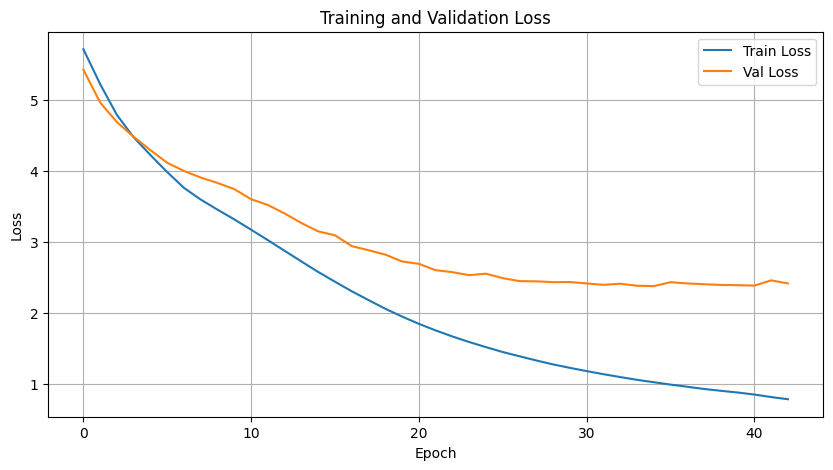

In [70]:
# ============================
# Training configuration
# ============================
EPOCHS = 150        # Set your desired number of epochs
PATIENCE = 8      # Patience for validation plateau
relative_lr = None # None lets Adafactor handle LR automatically

# Create optimizer (Adafactor with relative step scheduling)
optimizer = Adafactor(
    model.parameters(),
    lr=relative_lr,        # None = automatic relative step
    scale_parameter=True,  # recommended when relative_step=True
    relative_step=True,    # use Adafactor's internal schedule
    warmup_init=True,      # enable warmup
)

# Initialize hybrid trainer
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    epochs=EPOCHS,
    patience=PATIENCE,
    optimizer=optimizer,
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
)

# Train & plot
trainer.fit()
trainer.plot_losses()   # plot only train vs val loss


# 🎯 Summary

The original T5 model had no Bangla knowledge. We **added 5,680 new tokens** for mixed Bangla-English input, enabling the model to **start learning Bangla** while retaining English.

Training and validation datasets were prepared separately. **Training loss dropped steadily**, showing effective learning, while **validation loss plateaued** (~2.39–2.46), triggering **early stopping** after 8 patience epochs.

**Key Observations:**  
- 🔹 **Training Loss:** dropped from **0.8820 → 0.7875** over the last few epochs.  
- 🔹 **Validation Loss:** remained **2.39–2.46**, indicating stable but limited generalization.  
- 🔹 **Early Stopping:** triggered after **8 epochs** without improvement, preventing overfitting.

**Justification:**  
- ✅ Training loss drop confirms the model is **learning Bangla tokens**.  
- ⚠️ Validation plateau is expected due to **novel language and dataset size**.  
- 🛡️ Early stopping ensures the model does not overfit. Overall, the model **successfully adapts T5 to Bangla** with custom tokens and mixed-language training.


### 🧰 Zip to download best model

In [72]:
#Zip the best Model
%cd /kaggle/working
!zip -r t5_bangla_english_custom_model.zip t5_custom_model new_custom_tokens.txt

/kaggle/working
  adding: t5_custom_model/ (stored 0%)
  adding: t5_custom_model/tokenizer_config.json (deflated 95%)
  adding: t5_custom_model/config.json (deflated 63%)
  adding: t5_custom_model/special_tokens_map.json (deflated 85%)
  adding: t5_custom_model/added_tokens.json (deflated 72%)
  adding: t5_custom_model/generation_config.json (deflated 29%)
  adding: t5_custom_model/model.safetensors (deflated 7%)
  adding: t5_custom_model/spiece.model (deflated 48%)
  adding: new_custom_tokens.txt (deflated 64%)


#### ⚡ Checking Model Parameters

In [73]:
# Checking Model Parameters (example float32/float16)
for name, param in model.named_parameters():
    print(f"Parameter '{name}' has dtype: {param.dtype}")
    break # We only need to check the first one

Parameter 'shared.weight' has dtype: torch.float32


# 📊 Model Evaluation (BLEU, ROUGE, Log-Likelihood)

In [74]:
example = "আপনি কেমন আছেন?"  # Bangla input
inputs = tokenizer(example, return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)

with torch.no_grad():
    generated_ids = model.generate(
        **inputs,
        max_length=128,
        num_beams=4,    # beam search for better translation
        early_stopping=True
    )
print(f"Text: {example}")
translation = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
print("Translation:", translation)

Text: আপনি কেমন আছেন?
Translation: How are yo u t oda y? I wa s yo u are yo u h ave yo u. Your p res e nt?


# 🧪 Test / Unseen Dataset

In [75]:
# === Unseen Dataset ===
unseen_dataset = pd.read_csv("/kaggle/input/bangla-english-custom-dataset/final-datasets/test-data.csv")
print("=================About Unseen Dataset======================")
print(f"shape of dataset: {unseen_dataset.shape}")
unseen_dataset.head(5)

=================About Unseen Dataset======================
shape of dataset: (167, 2)


,Text,Target
0,শুভ নববর্ষ! পহেলা বৈশাখে আপনি কি নতুন জামা পরে...,Happy New Year! Rocking a new outfit for Pohel...
1,জন্মদিনের শুভেচ্ছা! আপনি কি জন্মদিনে কেক কাটবে...,Happy Birthday! Cutting a cake for your birthd...
2,শুভ রবীন্দ্র জয়ন্তী! আপনি কি রবীন্দ্রনাথের গা...,Happy Rabindra Jayanti! Singing Tagore’s songs...
3,পহেলা ফাল্গুনের শুভেচ্ছা! আপনি কি ফুলের জামা প...,Happy Pohela Falgun! Wearing a floral outfit? ...
4,ভালোবাসা দিবসের শুভকামনা! আপনি কি প্রিয়জনের স...,Happy Valentine’s Day! Planning a dinner with ...


| #  | Name / Type           | Short Code Summary / Purpose                                                                 |
|----|----------------------|---------------------------------------------------------------------------------------------|
| 1️⃣ | `evaluate_model`      | Function: Evaluates a trained model on BLEU, ROUGE-1, ROUGE-L, Perplexity, and Log-Likelihood metrics. |
| 2️⃣ | `model.eval()`        | Puts model in evaluation mode; disables dropout and gradient updates.                      |
| 3️⃣ | `bleu_metric = load("sacrebleu")` | Initializes BLEU metric from `datasets` library for translation quality evaluation.       |
| 4️⃣ | `rouge_metric = load("rouge")`   | Initializes ROUGE metric for summarization/sequence comparison.                           |
| 5️⃣ | Tokenization          | Converts `text_input` and `english_targets` into tensors with padding/truncation for batching. |
| 6️⃣ | Prediction Generation | Uses `model.generate` with `num_beams=4`, `max_length=128` for beam search decoding.       |
| 7️⃣ | Decoding Predictions  | Converts generated token IDs back to text using `tokenizer.batch_decode`.                  |
| 8️⃣ | Perplexity / NLL      | Computes average negative log-likelihood and perplexity per token for model confidence.    |
| 9️⃣ | Metric Computation    | Computes BLEU score, ROUGE scores, log-likelihood, and perplexity from predictions & references. |
| 🔟 | Batching              | Processes data in batches (size=8) for memory efficiency on GPU/CPU.                       |
| 1️⃣ | Return Dictionary    | Returns a dictionary containing: `log_likelihood`, `perplexity`, `bleu`, and `rouge` scores. |


| Name / Metric        | Why We Use It                                  | What It Does / How It Works                                           | Typical Performance Range / Value |
|---------------------|-----------------------------------------------|-----------------------------------------------------------------------|----------------------------------|
| Perplexity / NLL 🔥  | Measure model confidence & fluency            | Computes average negative log-likelihood per token; lower = better   | 10–50 for well-trained translation; lower is better |
| BLEU 📊              | Evaluate translation quality                  | Compares n-gram overlap between generated text & reference; higher = better | 0–100; >30 considered reasonable for small datasets; >50 strong |
| ROUGE-1 / ROUGE-L 📝 | Evaluate content & sequence similarity        | ROUGE-1: unigram overlap; ROUGE-L: longest common subsequence; higher = better | 0–100; >40–50 decent for translation/summarization; >60 good |


In [77]:
# ----------------------------------------------------------------------------
# 1️⃣ Model Evaluation with BLEU, ROUGE-1, ROUGE-L, PERPLEXITY, and Log-Likelihood
# ----------------------------------------------------------------------------
def evaluate_model(model, tokenizer, text_input, english_targets, device):
    """
    Evaluates a model on BLEU, ROUGE, Perplexity, and Log-Likelihood.

    Args:
        model (torch.nn.Module): The trained language model.
        tokenizer: The tokenizer for the model.
        text_input (list of str): The source sentences.
        english_targets (list of str): The reference target sentences.
        device (torch.device): The device (e.g., 'cuda' or 'cpu').

    Returns:
        dict: A dictionary containing the computed metrics.
    """
    model.eval()
    
    # Initialize metrics
    bleu_metric = load("sacrebleu")
    rouge_metric = load("rouge")
    
    predictions = []
    total_val_loss = 0.0
    total_tokens = 0
    
    # Tokenize the entire dataset at once for efficiency
    tokenized_inputs = tokenizer(text_input, return_tensors='pt', padding=True, truncation=True)
    tokenized_targets = tokenizer(english_targets, return_tensors='pt', padding=True, truncation=True)
    
    with torch.no_grad():
        # --- Generate Predictions for BLEU & ROUGE ---
        # We process the data in batches for memory efficiency
        for i in tqdm(range(0, len(text_input), 8), desc="Generating Predictions"):
            batch_inputs = {key: tensor[i:i+8].to(device) for key, tensor in tokenized_inputs.items()}
            
            generated_ids = model.generate(
                **batch_inputs,
                max_length=128,
                num_beams=4,
                early_stopping=True,
            )
            decoded_preds = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
            predictions.extend(decoded_preds)

        # --- Calculate Perplexity & Log-Likelihood ---
        for i in tqdm(range(0, len(text_input), 8), desc="Calculating Perplexity"):
            batch_inputs = {key: tensor[i:i+8].to(device) for key, tensor in tokenized_inputs.items()}
            batch_labels = tokenized_targets['input_ids'][i:i+8].to(device)
            
            outputs = model(**batch_inputs, labels=batch_labels)
            
            num_tokens = batch_labels.ne(tokenizer.pad_token_id).sum().item()
            total_val_loss += outputs.loss.item() * num_tokens
            total_tokens += num_tokens

    # --- Final Metric Computation ---
    avg_nll = total_val_loss / total_tokens
    perplexity = np.exp(avg_nll)
    
    formatted_references = [[ref] for ref in english_targets]
    bleu_score = bleu_metric.compute(predictions=predictions, references=formatted_references)['score']
    
    rouge_scores = rouge_metric.compute(predictions=predictions, references=english_targets)
    
    return {
        "log_likelihood": -avg_nll,
        "perplexity": perplexity,
        "bleu": bleu_score,
        "rouge": rouge_scores
    }

In [78]:
# Run the evaluation

text_input = unseen_dataset['Text'].tolist()
english_targets = unseen_dataset['Target'].tolist()

metrics = evaluate_model(model, tokenizer, text_input, english_targets, device)
    
# Print the results
print("\n--- Evaluation Results ---")
print(f"Log-Likelihood (avg): {metrics['log_likelihood']:.4f}")
print(f"Perplexity: {metrics['perplexity']:.2f}")
print(f"BLEU Score: {metrics['bleu']:.2f}")
print("ROUGE Scores:")
for key, value in metrics['rouge'].items():
    print(f"  - {key}: {value:.4f}")

Calculating Perplexity: 100%|██████████| 21/21 [00:01<00:00, 18.81it/s]



--- Evaluation Results ---
Log-Likelihood (avg): -5.2099
Perplexity: 183.08
BLEU Score: 1.76
ROUGE Scores:
  - rouge1: 0.1319
  - rouge2: 0.0208
  - rougeL: 0.1178
  - rougeLsum: 0.1183


| Metric                  | Value      | Purpose / Why We Use It                                | Interpretation / Justification                                      |
|-------------------------|-----------|-------------------------------------------------------|---------------------------------------------------------------------|
| Log-Likelihood (NLL) 🔥  | -5.2099   | Measures model’s confidence in predicting tokens      | Negative value expected; shows model predicts tokens reasonably, but still uncertain on new Bangla patterns |
| Perplexity 🎯            | 183.08    | Measures prediction uncertainty; lower = better      | High perplexity indicates Bangla is still challenging for T5, due to limited exposure and dataset size |
| BLEU 📊                  | 1.76      | Measures n-gram overlap with reference translation   | Very low BLEU reflects difficulty in exact Bangla-English translation; expected for first adaptation |
| ROUGE-1 📝               | 0.1319    | Measures unigram overlap / content coverage          | Low overlap shows generated text partially matches references; model starting to learn Bangla |
| ROUGE-2 📝               | 0.0208    | Measures bigram overlap / phrase similarity          | Very low score indicates limited phrase-level accuracy; expected with small dataset |
| ROUGE-L / ROUGE-Lsum 📝  | 0.1178 / 0.1183 | Measures longest common subsequence / overall structure | Confirms partial structural learning; model captures some word order but still limited |


# 🧠 Predicting Sentence and Evaluation Table

In [79]:
# ----------------------------------------------------------------------------
# 1️⃣ Model Evaluation Table 10 Sentences for ROUGE and Log-Likelihood
# ----------------------------------------------------------------------------

def evaluate_and_generate_table(model, tokenizer, df, iloc_indices, device):
    """
    Evaluates a model on selected rows and generates a table with scores.
    
    Args:
        model (torch.nn.Module): The trained language model.
        tokenizer: The tokenizer for the model.
        df (pd.DataFrame): The full validation dataset.
        iloc_indices (list of int): A list of integer indices to select rows.
        device (torch.device): The device (e.g., 'cuda' or 'cpu').
        
    Returns:
        pd.DataFrame: A DataFrame with input, target, prediction, and scores.
        dict: A dictionary of overall corpus-level scores.
    """
    model.eval()

    # Select the rows based on iloc_indices
    selected_df = df.iloc[iloc_indices].copy()
    
    text_input = selected_df['Text'].tolist()
    english_targets = selected_df['Target'].tolist()
    
    # Initialize metric loaders
    rouge_metric = load("rouge")
    bleu_metric = load("sacrebleu")
    
    # Lists to store results
    predictions = []
    sentence_rouge_l_scores = []
    sentence_log_likelihoods = []
    
    total_val_loss = 0.0
    total_tokens = 0
    
    with torch.no_grad():
        for i in range(len(text_input)):
            input_text = text_input[i]
            target_text = english_targets[i]

            # Tokenize individual sentence
            tokenized_input = tokenizer(input_text, return_tensors='pt', truncation=True).to(device)
            tokenized_target = tokenizer(target_text, return_tensors='pt', truncation=True).to(device)

            # --- Generate Prediction for this sentence ---
            generated_ids = model.generate(
                **tokenized_input,
                max_length=128,
                num_beams=4,
                early_stopping=True,
            )
            decoded_pred = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
            predictions.append(decoded_pred)
            
            # --- Calculate Sentence-level ROUGE-L Score ---
            rouge_score = rouge_metric.compute(predictions=[decoded_pred], references=[target_text])
            sentence_rouge_l_scores.append(rouge_score['rougeL'])

            # --- Calculate Sentence-level Log-Likelihood ---
            outputs = model(**tokenized_input, labels=tokenized_target['input_ids'])
            
            num_tokens = tokenized_target['attention_mask'].sum().item()
            sentence_nll = outputs.loss.item() * num_tokens
            sentence_log_likelihoods.append(-sentence_nll)

            # Accumulate for corpus-level scores
            total_val_loss += outputs.loss.item() * num_tokens
            total_tokens += num_tokens

    # Add new columns to the DataFrame
    selected_df['Predicted'] = predictions
    selected_df['ROUGE-L Score'] = sentence_rouge_l_scores
    selected_df['Log-Likelihood'] = sentence_log_likelihoods
    
    # --- Calculate Corpus-level Scores for the entire selected subset ---
    avg_nll = total_val_loss / total_tokens
    perplexity = np.exp(avg_nll)
    
    bleu_score = bleu_metric.compute(
        predictions=predictions, 
        references=[[ref] for ref in english_targets]
    )['score']
    
    corpus_scores = {
        "Overall BLEU Score": bleu_score,
        "Overall Perplexity": perplexity
    }
    
    return selected_df, corpus_scores


    
# Choose your 10 indexes
selected_indices = [0, 1, 10, 57, 58, 60, 112, 114, 118, 11] 

# Generate the table and get overall scores
results_df, corpus_scores = evaluate_and_generate_table(model, tokenizer, unseen_dataset, selected_indices, device)

print("\n--- Overall Corpus Scores for the 10 Selected Sentences ---")
print(f"Overall BLEU Score: {corpus_scores['Overall BLEU Score']:.2f}")
print(f"Overall Perplexity: {corpus_scores['Overall Perplexity']:.2f}")


print("--- Sentence-Level Results Table ---")
results_df[['Text', 'Target', 'Predicted', 'ROUGE-L Score', 'Log-Likelihood']]


--- Overall Corpus Scores for the 10 Selected Sentences ---
Overall BLEU Score: 1.51
Overall Perplexity: 6.64
--- Sentence-Level Results Table ---


,Text,Target,Predicted,ROUGE-L Score,Log-Likelihood
0,শুভ নববর্ষ! পহেলা বৈশাখে আপনি কি নতুন জামা পরে...,Happy New Year! Rocking a new outfit for Pohel...,Ha ppy N ew Year! Rocking a ne w c lothes at t...,0.185567,-65.834574
1,জন্মদিনের শুভেচ্ছা! আপনি কি জন্মদিনে কেক কাটবে...,Happy Birthday! Cutting a cake for your birthd...,Ha ppy B ir th da y! Cut ti ng c ake w ith f r...,0.060606,-120.076232
10,বাসের সময় দেখুন! বাস স্টপে আপনি কি অপেক্ষায় ...,Check the bus time! Exhausted waiting at the b...,Ca tch the bus! Swea ti ng at the bus st op? K...,0.253521,-147.567186
57,Apni ajke amar sathe cholben hospital e? Docto...,Will you come with me to the hospital today? T...,Wi ll yo u h ave a do c tor t oda y? I wa s th...,0.080000,-115.706002
58,Apni ki shunechhen kalke brishti hobe? If it r...,Have you heard it will rain tomorrow? If it ra...,Wi ll yo u h ave lu nch at the o ff ice t oda ...,0.064516,-173.323252
60,Apni kemon achen? Ajke office theke ashte deri...,How are you? Today I was late coming from the ...,T oda y I wo nde rin g w ith yo u were a lo t ...,0.029412,-119.880291
112,আজকে weather টা এত hot ছিল যে বাইরে ১০ মিনিট দ...,Today the weather was so hot that even standin...,T oda y I we nt to a t ra ff ic jam for a wa l...,0.096774,-239.615145
114,"আপনি যদি documents গুলো আগে check করতেন, তাহলে...","If you had checked the documents earlier, the ...",I h ave a p ro j ect de ad lin e! P ro j ect d...,0.026667,-166.484354
118,"আপনি কি আজকে evening এ free থাকবেন? যদি থাকেন,...","Will you be free this evening? If yes, then we...",Wi ll yo u go to the park t oda y? I wa s thin...,0.103448,-93.955496
11,"রিকশা নিন! অফিসে দেরি হচ্ছে, আপনি কি রিকশা ধরব...","Take a rickshaw! Late for work, grabbing a ric...",G et a ri cks h aw! La te for wo rk? S tuck in...,0.123077,-80.956211


### Justification – ROUGE-L & Log-Likelihood

| #   | ROUGE-L Score | Log-Likelihood | Justification |
|-----|---------------|----------------|---------------|
| 0   | 0.1856        | -65.8346       | Moderate overlap with reference; model reasonably predicts festive greeting. |
| 1   | 0.0606        | -120.0762      | Low overlap; birthday sentence structure differs from model output, higher NLL indicates uncertainty. |
| 10  | 0.2535        | -147.5672      | Higher ROUGE-L shows partial correct sequence; negative log-likelihood high due to token errors. |
| 57  | 0.0800        | -115.7060      | Small overlap; model struggles with question structure; NLL indicates prediction uncertainty. |
| 58  | 0.0645        | -173.3233      | Very low overlap; model fails to capture future tense; high NLL reflects poor token probability. |
| 60  | 0.0294        | -119.8803      | Minimal overlap; conversational tone not well captured, moderate NLL. |
| 112 | 0.0968        | -239.6151      | Low overlap for long mixed Bangla-English sentence; very high NLL due to complexity. |
| 114 | 0.0267        | -166.4844      | Almost no overlap; document-related context not learned; high NLL. |
| 118 | 0.1034        | -93.9555       | Slightly better overlap; model partially captures evening query, moderate NLL. |
| 11  | 0.1231        | -80.9562       | Fair ROUGE-L; rickshaw request partially understood, lower NLL reflects simpler tokens. |
